In [14]:
####### dropout resnet18 vs without dropout
#### 
import torch
import sys
sys.path.append("..")
import numpy as np

TAR_PATH = "/home/yifan/dataset/clean/pairflip/cifar10/0"
REF_PATH = "/home/yifan/experiments/noise/20/experiment1"


ENCODER_DIMS=[512,256,256,256,256,2]
DECODER_DIMS= [2,256,256,256,256,512]
VIS_MODEL_NAME = 'baseline'

DEVICE='cuda:1'
########## initulize reference data and target data
from AlignVis.DataInit import DataInit
REF_EPOCH = 200
TAR_EPOCH = 200
tar_datainit = DataInit(TAR_PATH,TAR_PATH,TAR_EPOCH,DEVICE)
ref_datainit = DataInit(REF_PATH,REF_PATH,REF_EPOCH,DEVICE)

ref_model, ref_provider, ref_train_data, ref_prediction, ref_prediction_res, ref_scores = ref_datainit.getData()
tar_model, tar_provider, tar_train_data, tar_prediction, tar_prediction_res, tar_scores = tar_datainit.getData()


from AlignVis.ReferenceGenerator import ReferenceGenerator
gen = ReferenceGenerator(ref_provider=ref_provider, tar_provider=tar_provider,REF_EPOCH=REF_EPOCH,TAR_EPOCH=TAR_EPOCH,ref_model=ref_model,tar_model=tar_model,DEVICE=DEVICE)

absolute_alignment_indicates,predict_label_diff_indicates,predict_confidence_Diff_indicates,high_distance_indicates = gen.subsetClassify(18,0.8,0.3,0.05)


from AlignVis_Visualizer.visualizer import visualizer
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)

I = np.eye(512)
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
vis = visualizer(ref_provider, I,I, np.dot(ref_provider.train_representation(TAR_EPOCH),I), projector, 200,[0,1],'tab10')


NET resnet18
Finish initialization...


100%|██████████| 250/250 [00:00<00:00, 8710.69it/s]


NET resnet18
Finish initialization...


100%|██████████| 250/250 [00:00<00:00, 8817.94it/s]


absolute alignment indicates number: 4 label diff indicates number: 10042 confidence diff indicates number: 31 high distance number: 12493


In [16]:

####### generate boundary ponits for tar and ref respectively
from AlignVis.AlignmentBoundaryGenerator import AlignmentBoundaryGenerator
BoundaryGen = AlignmentBoundaryGenerator(REF_PATH,REF_PATH,TAR_PATH,TAR_PATH,REF_EPOCH,TAR_EPOCH,DEVICE)
ref_boundary,tar_boundary = BoundaryGen.get_boundary_point(DEVICE,num_adv_eg=2000)
import torch
###### get border sample features
import torch.nn as nn

ref_feature_model = ref_model.to(DEVICE)
ref_feature_model = nn.Sequential(*list(ref_feature_model.children())[:-1])
with torch.no_grad():
    features = ref_feature_model(ref_boundary)
    ref_features = features.view(ref_boundary.shape[0], -1).cpu().numpy()

###### get border sample features
tar_feature_model = tar_model.to(DEVICE)
tar_feature_model = nn.Sequential(*list(tar_feature_model.children())[:-1])
with torch.no_grad():
    tar_features = tar_feature_model(tar_boundary)
    tar_features = tar_features.view(tar_boundary.shape[0], -1).cpu().numpy()

NET resnet18
Finish initialization...


100%|██████████| 250/250 [00:00<00:00, 8781.97it/s]


NET resnet18
Finish initialization...


100%|██████████| 250/250 [00:00<00:00, 8183.50it/s]


RuntimeError: CUDA out of memory. Tried to allocate 586.00 MiB (GPU 1; 14.75 GiB total capacity; 1.70 GiB already allocated; 371.94 MiB free; 2.11 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [15]:
import os
ref_border_path = os.path.join(TAR_PATH,"Model", "Epoch_{:d}".format(TAR_EPOCH),
                                          "aligned_ref_border.npy")
tar_border_path = os.path.join(TAR_PATH,"Model", "Epoch_{:d}".format(TAR_EPOCH),
                                          "aligned_tar_border.npy")
if os.path.exists(ref_border_path) and os.path.exists(tar_border_path):
    print("aaa")
    ref_border_centers_loc = os.path.join(TAR_PATH,"Model", "Epoch_{:d}".format(TAR_EPOCH),
                                          "aligned_ref_border.npy")
    ref_features = np.load(ref_border_centers_loc).squeeze()
    tar_border_centers_loc = os.path.join(TAR_PATH,"Model", "Epoch_{:d}".format(TAR_EPOCH),
                                          "aligned_tar_border.npy")
    tar_features = np.load(tar_border_centers_loc).squeeze()

In [3]:
from AlignVis_eval.AlignEval import Evaluator
eval = Evaluator(projector,ref_provider,tar_provider,REF_EPOCH,TAR_EPOCH)
eval.eval_boundary_nn_ref_in_ref(ref_features, 15)

#train# boundary preserving: 1.41/15 in epoch 200


1.41334

In [3]:
import os
location_R = os.path.join(TAR_PATH, "Model","Epoch_{:d}".format(TAR_EPOCH), "aligned_ref_border.npy")
location_T = os.path.join(TAR_PATH, "Model","Epoch_{:d}".format(TAR_EPOCH), "aligned_tar_border.npy")
np.save(location_R, ref_features)
np.save(location_T, tar_features)

In [5]:
######### initialize autoencoder and dataloader #########################
from AlignVisAutoEncoder.autoencoder import SimpleAutoencoder
from AlignVisAutoEncoder.data_loader import DataLoaderInit
input_dim = 512
output_dim = 512

autoencoder = SimpleAutoencoder(input_dim,output_dim)
######### train sample + generated boundary sample's => input  #############
input_X = np.concatenate((ref_provider.train_representation(REF_EPOCH), ref_features),axis=0)
input_Y = np.concatenate((tar_provider.train_representation(TAR_EPOCH), tar_features),axis=0)
data_loader_b = DataLoaderInit(input_X, input_Y, batch_size=100)
data_loader = DataLoaderInit(ref_provider.train_representation(REF_EPOCH), tar_provider.train_representation(TAR_EPOCH), batch_size=100)
dataloader = data_loader.get_data_loader()
dataloader_b = data_loader_b.get_data_loader()

In [6]:
import torch.optim as optim
import numpy as np
from pyemd import emd
import torch.nn as nn
from scipy.spatial.distance import cdist
from sklearn.neighbors import kneighbors_graph
import torch.nn.functional as F
from AlignVis.losses import KNNOverlapLoss, CKALoss, PredictionLoss, ConfidenceLoss


def earth_movers_distance(X, Y, k=5):
    X, Y = X.detach().numpy(), Y.detach().numpy()
    
    # Compute KNN graphs
    X_knn_graph = kneighbors_graph(X, k, mode='distance')
    Y_knn_graph = kneighbors_graph(Y, k, mode='distance')
    
    # Convert to dense NumPy arrays
    X_knn_matrix = X_knn_graph.toarray()
    Y_knn_matrix = Y_knn_graph.toarray()

    # Calculate the EMD between the KNN distance matrices
    distance_matrix = cdist(X_knn_matrix, Y_knn_matrix)
    first_histogram = np.ones(X_knn_matrix.shape[0]) / X_knn_matrix.shape[0]
    second_histogram = np.ones(Y_knn_matrix.shape[0]) / Y_knn_matrix.shape[0]

    return emd(first_histogram, second_histogram, distance_matrix)

def frobenius_norm_loss(predicted, target):
    return torch.norm(predicted - target, p='fro') / predicted.numel()

def prediction_loss(trans_X, Y):
    
    target_output = tar_provider.get_pred(TAR_EPOCH, Y.detach().numpy())
    # tar_output = self.get_pred(self.TAR_EPOCH, adjusted_input, self.tar_provider.content_path, self.tar_model)
    ref_output = tar_provider.get_pred(TAR_EPOCH, trans_X.detach().numpy())

    loss_ref_output = F.mse_loss(torch.tensor(ref_output), torch.tensor(target_output))
    loss_Rep = F.mse_loss(trans_X, Y)
        
    # loss = loss_tar_output + loss_Rep + self.alpha_for_pred_ref * loss_ref_output
    loss =  loss_Rep + 1 * loss_ref_output
    return loss

# Define hyperparameters
num_epochs = 10
batch_size = 50
learning_rate = 1e-4

# Define the loss function and the optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate,weight_decay=1e-5)

alpha = 1 # weight for topological loss, adjust this according to your requirements


# Training loop
for epoch in range(num_epochs):
    # Initialize a list to store the predictions of unlabelled data
    unlabelled_preds = []
    for data_X, data_Y in dataloader_b: # Assuming you have a DataLoader instance with paired data (X, Y)
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass (encoding Y and decoding to X's space)
        transformed_Y = autoencoder.encoder(data_Y)
        recon_X = autoencoder.decoder(transformed_Y)

        topological_loss_encoder = earth_movers_distance(data_Y, transformed_Y)
        topological_loss_decoder = earth_movers_distance(data_Y, recon_X)
        
        loss_f_decoder = frobenius_norm_loss(recon_X, data_X) + 10 * topological_loss_decoder
        loss_f_encoder = frobenius_norm_loss(transformed_Y, data_X) + topological_loss_encoder

        pred_loss = prediction_loss(recon_X, data_Y)

        #### CKA loss
        cka_loss_f = CKALoss(gamma=None, alpha=1e-8)
        cka_loss = cka_loss_f(data_Y,transformed_Y,recon_X)

        loss = loss_f_decoder + loss_f_encoder + 0.01 * pred_loss + cka_loss

        # Backward pass
        loss.backward()

        # Update the weights
        optimizer.step()


    # Print the loss for each epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Loss decoder: {loss_f_decoder.item():.4f},Loss encoder: {loss_f_encoder.item():.4f},pred_loss,{pred_loss.item():.4f},CKA,{cka_loss.item():.4f}')

torch.save({
    'epoch': TAR_EPOCH,
    'model_state_dict': autoencoder.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss
}, "/home/yifan/projects/deepdebugertool/DLVisDebugger/AlignVisAutoEncoder/checkpoints/noise_12_233.pth")


100%|██████████| 1/1 [00:00<00:00, 3912.60it/s]


KeyboardInterrupt: 

In [8]:
from AlignVis.autoencoder_generator import AutoEncoderGenerator
AutoEncoder_Generator = AutoEncoderGenerator(REF_PATH, REF_PATH, TAR_PATH, TAR_PATH, 200,200, projector, DEVICE)
import os
if os.path.exists(os.path.join(TAR_PATH, "pre_autoencoder_.npy")):
    print("continue")
    autoencoder = AutoEncoder_Generator.encoder_trainer_with_pre_trained(os.path.join(TAR_PATH, "pre_autoencoder_.npy"), os.path.join(TAR_PATH, "pre_autoencoder_.npy"),batch_size=500,num_epochs=5,learning_rate=1e-2)
else:
    print("new one")
    autoencoder = AutoEncoder_Generator.encoder_trainer(os.path.join(TAR_PATH, "pre_autoencoder_.npy"),batch_size=500,num_epochs=5,learning_rate=1e-2)

NET resnet18
Finish initialization...


100%|██████████| 250/250 [00:00<00:00, 8701.37it/s]

NET resnet18


Finish initialization...


100%|██████████| 250/250 [00:00<00:00, 8663.91it/s]


new one
NET resnet18
Finish initialization...


100%|██████████| 250/250 [00:00<00:00, 8563.86it/s]

NET resnet18
Finish initialization...



100%|██████████| 3/3 [00:00<00:00, 8300.07it/s]


Epoch [1/5], Loss: 2.6055, Loss decoder: 0.0008,Loss encoder: 0.0026,flip_loss: 60.92579650878906,pred_loss:1.919594168663025,loss_contrastive0.0,cka_loss0.07331031560897827


100%|██████████| 3/3 [00:00<00:00, 7362.73it/s]


Epoch [2/5], Loss: 2.4521, Loss decoder: 0.0008,Loss encoder: 0.0025,flip_loss: 61.06302261352539,pred_loss:1.7687246799468994,loss_contrastive0.0,cka_loss0.06947040557861328


100%|██████████| 3/3 [00:00<00:00, 7552.77it/s]


Epoch [3/5], Loss: 2.2697, Loss decoder: 0.0008,Loss encoder: 0.0025,flip_loss: 61.074798583984375,pred_loss:1.5846139192581177,loss_contrastive0.0,cka_loss0.07109010219573975


100%|██████████| 3/3 [00:00<00:00, 9225.01it/s]


Epoch [4/5], Loss: 2.2339, Loss decoder: 0.0008,Loss encoder: 0.0025,flip_loss: 60.716949462890625,pred_loss:1.5513811111450195,loss_contrastive0.0,cka_loss0.0720873475074768


100%|██████████| 3/3 [00:00<00:00, 5703.95it/s]


Epoch [5/5], Loss: 2.4126, Loss decoder: 0.0008,Loss encoder: 0.0024,flip_loss: 60.78103256225586,pred_loss:1.7331349849700928,loss_contrastive0.0,cka_loss0.06844031810760498


Computing decision regions ...


100%|██████████| 250/250 [00:00<00:00, 5482.18it/s]


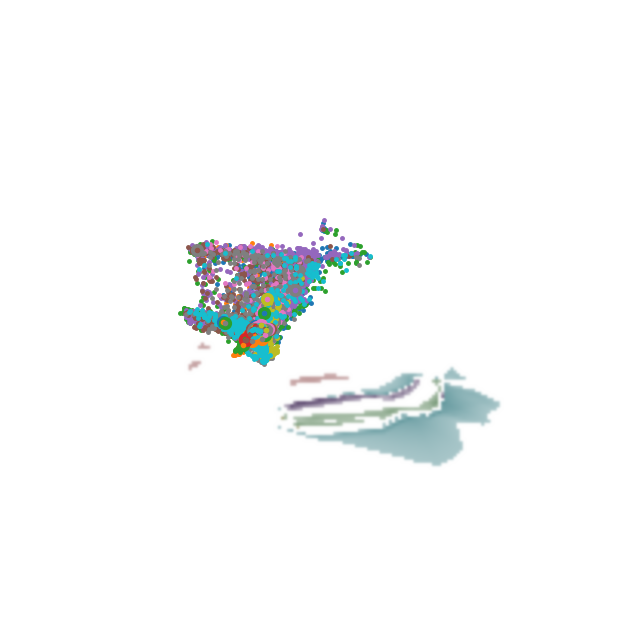

In [9]:
##### visuallize all data
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
VIS_MODEL_NAME = 'vis'
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
Y = torch.Tensor(tar_provider.train_representation(TAR_EPOCH))
encoded_Y = autoencoder.encoder(Y)
I = np.eye(512)
from AlignVis_Visualizer.visualizer import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(tar_provider, ref_provider, autoencoder, np.dot(encoded_Y.detach().numpy(), I), projector, 200,[],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(REF_EPOCH, path=os.path.join(TAR_PATH, "vis.png"))

In [13]:

####### generate boundary ponits for tar and ref respectively
from AlignVis.AlignmentBoundaryGenerator import AlignmentBoundaryGenerator
BoundaryGen = AlignmentBoundaryGenerator(REF_PATH,REF_PATH,TAR_PATH,TAR_PATH,REF_EPOCH,TAR_EPOCH,DEVICE)
ref_boundary,tar_boundary = BoundaryGen.get_boundary_point(DEVICE,num_adv_eg=2000)
import torch
###### get border sample features
import torch.nn as nn

ref_feature_model = ref_model.to(DEVICE)
ref_feature_model = nn.Sequential(*list(ref_feature_model.children())[:-1])
with torch.no_grad():
    features = ref_feature_model(ref_boundary)
    ref_features = features.view(ref_boundary.shape[0], -1).cpu().numpy()

###### get border sample features
tar_feature_model = tar_model.to(DEVICE)
tar_feature_model = nn.Sequential(*list(tar_feature_model.children())[:-1])
with torch.no_grad():
    tar_features = tar_feature_model(tar_boundary)
    tar_features = tar_features.view(tar_boundary.shape[0], -1).cpu().numpy()

NameError: name 'CLEAN_PATH' is not defined

In [28]:
eval.eval_boundary_nn_ref_in_ref(ref_features, 15)

#train# boundary preserving: 1.29/15 in epoch 200


1.29498

In [29]:
import os
location_R = os.path.join(TAR_PATH, "Model","Epoch_{:d}".format(TAR_EPOCH), "aligned_ref_border.npy")
location_T = os.path.join(TAR_PATH, "Model","Epoch_{:d}".format(TAR_EPOCH), "aligned_tar_border.npy")
np.save(location_R, ref_features)
np.save(location_T, tar_features)

In [19]:
######### initialize autoencoder and dataloader #########################
from AlignVisAutoEncoder.autoencoder import SimpleAutoencoder
from AlignVisAutoEncoder.data_loader import DataLoaderInit
input_dim = 512
output_dim = 512

autoencoder = SimpleAutoencoder(input_dim,output_dim)

In [20]:



######### train sample + generated boundary sample's => input  #############
input_X = np.concatenate((ref_provider.train_representation(REF_EPOCH), ref_features),axis=0)
input_Y = np.concatenate((tar_provider.train_representation(TAR_EPOCH), tar_features),axis=0)
data_loader_b = DataLoaderInit(input_X, input_Y, batch_size=100)
data_loader = DataLoaderInit(ref_provider.train_representation(REF_EPOCH), tar_provider.train_representation(TAR_EPOCH), batch_size=100)
dataloader = data_loader.get_data_loader()
dataloader_b = data_loader_b.get_data_loader()


In [22]:
VIS_MODEL_NAME = 'vis'

In [23]:
import torch.optim as optim
import numpy as np
from pyemd import emd
import torch.nn as nn
from scipy.spatial.distance import cdist
from sklearn.neighbors import kneighbors_graph
import torch.nn.functional as F
from AlignVis.losses import KNNOverlapLoss, CKALoss, PredictionLoss, ConfidenceLoss

checkpoint = torch.load("/home/yifan/projects/deepdebugertool/DLVisDebugger/AlignVisAutoEncoder/checkpoints/noise_1_233.pth")
autoencoder.load_state_dict(checkpoint['model_state_dict'])

# BoundaryGen = AlignmentBoundaryGenerator(self.REF_PATH,self.TAR_PATH,self.REF_PATH,self.TAR_PATH,self.REF_EPOCH,self.TAR_EPOCH,self.DEVICE)

       
        


def earth_movers_distance(X, Y, k=5):
    X, Y = X.detach().numpy(), Y.detach().numpy()
    
    # Compute KNN graphs
    X_knn_graph = kneighbors_graph(X, k, mode='distance')
    Y_knn_graph = kneighbors_graph(Y, k, mode='distance')
    
    # Convert to dense NumPy arrays
    X_knn_matrix = X_knn_graph.toarray()
    Y_knn_matrix = Y_knn_graph.toarray()

    # Calculate the EMD between the KNN distance matrices
    distance_matrix = cdist(X_knn_matrix, Y_knn_matrix)
    first_histogram = np.ones(X_knn_matrix.shape[0]) / X_knn_matrix.shape[0]
    second_histogram = np.ones(Y_knn_matrix.shape[0]) / Y_knn_matrix.shape[0]

    return emd(first_histogram, second_histogram, distance_matrix)

def frobenius_norm_loss(predicted, target):
    return torch.norm(predicted - target, p='fro') / predicted.numel()

def prediction_loss(trans_X, Y):
    
    target_output = tar_provider.get_pred(TAR_EPOCH, Y.detach().numpy())
    # tar_output = self.get_pred(self.TAR_EPOCH, adjusted_input, self.tar_provider.content_path, self.tar_model)
    ref_output = tar_provider.get_pred(TAR_EPOCH, trans_X.detach().numpy())

    loss_ref_output = F.mse_loss(torch.tensor(ref_output), torch.tensor(target_output))
    loss_Rep = F.mse_loss(trans_X, Y)
        
    # loss = loss_tar_output + loss_Rep + self.alpha_for_pred_ref * loss_ref_output
    loss =  loss_Rep + 1 * loss_ref_output
    return loss

# Define hyperparameters
num_epochs = 10
batch_size = 50
learning_rate = 1e-4

# Define the loss function and the optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate,weight_decay=1e-5)
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

alpha = 1 # weight for topological loss, adjust this according to your requirements


# Training loop
for epoch in range(num_epochs):
    # Initialize a list to store the predictions of unlabelled data
    unlabelled_preds = []
    for data_X, data_Y in dataloader_b: # Assuming you have a DataLoader instance with paired data (X, Y)
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass (encoding Y and decoding to X's space)
        transformed_Y = autoencoder.encoder(data_Y)
        recon_X = autoencoder.decoder(transformed_Y)

        topological_loss_encoder = earth_movers_distance(data_Y, transformed_Y)
        topological_loss_decoder = earth_movers_distance(data_Y, recon_X)
        
        loss_f_decoder = frobenius_norm_loss(recon_X, data_X) + 10 * topological_loss_decoder
        loss_f_encoder = frobenius_norm_loss(transformed_Y, data_X) + topological_loss_encoder

        pred_loss = prediction_loss(recon_X, data_Y)

        #### CKA loss
        cka_loss_f = CKALoss(gamma=None, alpha=1e-8)
        cka_loss = cka_loss_f(data_Y,transformed_Y,recon_X)

        loss = loss_f_decoder + loss_f_encoder + 0.01 * pred_loss + cka_loss

        # Backward pass
        loss.backward()

        # Update the weights
        optimizer.step()


    # Print the loss for each epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Loss decoder: {loss_f_decoder.item():.4f},Loss encoder: {loss_f_encoder.item():.4f},pred_loss,{pred_loss.item():.4f},CKA,{cka_loss.item():.4f}')

torch.save({
    'epoch': TAR_EPOCH,
    'model_state_dict': autoencoder.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss
}, os.path.join(TAR_PATH,"pre_autoencoder.pth"))


100%|██████████| 1/1 [00:00<00:00, 4686.37it/s]


KeyboardInterrupt: 

In [ ]:
from AlignVis.autoencoder_generator import AutoEncoderGenerator
AutoEncoder_Generator = AutoEncoderGenerator(REF_PATH, REF_PATH, TAR_PATH, TAR_PATH, 200,200, projector, DEVICE)
import os
if os.path.exists(os.path.join(TAR_PATH, "pre_autoencoder.npy")):
    print("continue")
    autoencoder = AutoEncoder_Generator.encoder_trainer_with_pre_trained(os.path.join(TAR_PATH, "pre_autoencoder.npy"), os.path.join(TAR_PATH, "pre_autoencoder.npy"),batch_size=500,num_epochs=5,learning_rate=1e-2)
else:
    print("new one")
    autoencoder = AutoEncoder_Generator.encoder_trainer(os.path.join(TAR_PATH, "pre_autoencoder.npy"),batch_size=500,num_epochs=10)

In [26]:
autoencoder = SimpleAutoencoder(input_dim,output_dim)
checkpoint = torch.load("/home/yifan/projects/deepdebugertool/DLVisDebugger/AlignVisAutoEncoder/checkpoints/ref_noise_pre0.1.pth")
autoencoder.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [8]:
###### use auto encoder to visualize the prediction
X = torch.Tensor(ref_provider.train_representation(REF_EPOCH))
Y = torch.Tensor(tar_provider.train_representation(TAR_EPOCH))
# Transform X into Y's space
encoded_X = autoencoder.decoder(X)

# Transform Y into X's space
encoded_Y = autoencoder.encoder(Y)
c_y = encoded_Y.detach().numpy()

from CKA_utils.CKA import CKA, CudaCKA
np_cka = CKA()
# indicates = np.random.choice(aligned, size=10, replace=False)
indicates = np.random.choice(np.arange(5000), size=1000, replace=False)
print('CKA between  target vs target is:         ',np_cka.kernel_CKA(Y[indicates],Y[indicates]))
# print('CKA between target and linear_target:     ',np_cka.kernel_CKA(Y[indicates],np.dot(Y[indicates],R_n_2.detach().numpy())))
print('CKA between target and autoencoder_target:',np_cka.kernel_CKA(Y[indicates],c_y[indicates]))
print('CKA between  ref vs autoencoder_target is:',np_cka.kernel_CKA(X[indicates],c_y[indicates]))
print('CKA between  ref vs target is:            ',np_cka.kernel_CKA(X[indicates],c_y[indicates]))

CKA between  target vs target is:          1.0
CKA between target and autoencoder_target: 0.9936928080630163
CKA between  ref vs autoencoder_target is: 0.7869676320307327
CKA between  ref vs target is:             0.7869676320307327


In [10]:
from AlignVis_eval.AlignEval import Evaluator
eval = Evaluator(projector,ref_provider,tar_provider,REF_EPOCH,TAR_EPOCH)
eval.eval_boundary_nn_ref_in_ref(ref_features, 15)
# eval.eval_boundary_nn_autoencoder(tar_border_centers, autoencoder)

In [23]:
eval.eval_boundary_nn_ref_in_ref(ref_features, 15)

#train# boundary preserving: 1.37/15 in epoch 200


1.3666

In [24]:
from AlignVis_eval.AlignEval import Evaluator
eval = Evaluator(projector,ref_provider,tar_provider,REF_EPOCH,TAR_EPOCH)
eval.eval_boundary_nn_autoencoder(tar_features, autoencoder)

#train# boundary preserving: 2.58/15 in epoch 200


2.5756

In [30]:
eval.eval_nn_train_autoencoder(15,autoencoder)

Fri May 12 12:27:41 2023 Building RP forest with 16 trees
Fri May 12 12:27:42 2023 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	Stopping threshold met -- exiting after 4 iterations
Fri May 12 12:28:03 2023 Building RP forest with 16 trees
Fri May 12 12:28:04 2023 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	Stopping threshold met -- exiting after 2 iterations
#train# nn preserving for autoencoder: 1.25/15 in epoch 200


1.25114

In [31]:
eval.eval_move_direction_preserving(autoencoder,10,3)

100%|██████████| 250/250 [00:00<00:00, 2710.96it/s]


long distance move subet number is 23893, short distance move set number is 13


100%|██████████| 250/250 [00:00<00:00, 2868.98it/s]


all reference distance preserving 49409/50000
all target distance preserving 47630/50000
short distance move direction preserving 13/13
long distance move direction preserving 22513/23893


In [32]:
val_same, val_diff = eval.eval_prediction_preserving(autoencoder)

100%|██████████| 250/250 [00:00<00:00, 2551.38it/s]

refere  predction preserving:46512/50000 0.93
target  predction preserving:42945/50000 0.86
ref&tar pred_same preserving:35993/43892 0.82
ref&tar pred_diff preserving:5026/6108 0.82


In [12]:
def eval_boundary_align_sensitivity(autoencoder, tar_b_features, ref_b_features):
        ############## init ###################
        #init target
        print("123")
        tar_b_pred = tar_provider.get_pred(TAR_EPOCH, tar_b_features)
        tar_b_pred = tar_b_pred + 1e-8
        tar_sort_preds = np.sort(tar_b_pred, axis=1)
        tar_diff = (tar_sort_preds[:, -1] - tar_sort_preds[:, -2]) / (tar_sort_preds[:, -1] - tar_sort_preds[:, 0])
        tar_border = np.zeros(len(tar_diff), dtype=np.uint8) + 0.05
        tar_border[tar_diff < 0.15] = 1

        #init reference
        ref_b_pred = ref_provider.get_pred(REF_EPOCH, ref_b_features)
        ref_b_pred = ref_b_pred + 1e-8
        ref_sort_preds = np.sort(ref_b_pred, axis=1)
        ref_diff = (ref_sort_preds[:, -1] - ref_sort_preds[:, -2]) / (ref_sort_preds[:, -1] - ref_sort_preds[:, 0])
        ref_border = np.zeros(len(ref_diff), dtype=np.uint8) + 0.05
        ref_border[ref_diff < 0.15] = 1
        
        ##### get all boundary list
        all_boundary_list = []
        
        for i in range(len(ref_border)):
            if ref_border[i] == 1 and tar_border[i] == 1:
                all_boundary_list.append(i)
        print(len(all_boundary_list))
        #### get ref low dimensional border
        ref_b_embedding = projector.batch_project(REF_EPOCH, ref_b_features)
        ref_b_inv = projector.batch_inverse(REF_EPOCH,ref_b_embedding)
        ref_b_pred_l = ref_provider.get_pred(REF_EPOCH, ref_b_inv)
        ref_b_pred_l = ref_b_pred_l  + 1e-8
        ref_sort_preds_l  = np.sort(ref_b_pred_l , axis=1)
        ref_diff_l  = (ref_sort_preds_l[:, -1] - ref_sort_preds_l[:, -2]) / (ref_sort_preds_l[:, -1] - ref_sort_preds_l[:, 0])
        ref_border_l = np.zeros(len(ref_diff_l), dtype=np.uint8) + 0.05
        ref_border_l[ref_diff_l < 0.15] = 1
        
        #### get target low dimensional border
        tar_b_embedding = projector.batch_project(REF_EPOCH, autoencoder.encoder(torch.Tensor(ref_b_features)).detach().numpy())
        tar_b_inv = projector.batch_inverse(REF_EPOCH,tar_b_embedding)
        tar_b_inv = autoencoder.decoder(torch.Tensor(tar_b_inv)).detach().numpy()
        tar_b_pred_l = tar_provider.get_pred(REF_EPOCH, tar_b_inv)
        tar_b_pred_l = tar_b_pred_l  + 1e-8
        tar_sort_preds_l  = np.sort(tar_b_pred_l , axis=1)
        tar_diff_l  = (tar_sort_preds_l[:, -1] - tar_sort_preds_l[:, -2]) / (tar_sort_preds_l[:, -1] - tar_sort_preds_l[:, 0])
        tar_border_l = np.zeros(len(tar_diff_l), dtype=np.uint8) + 0.05
        tar_border_l[tar_diff_l < 0.15] = 1

        all_boundary_list_l = []
       
        all_change = []
        all_change_l=[]
      
        for i in range(len(ref_border)):
            ##### low dimension all border
            if ref_border_l[i] == 1 and tar_border_l[i] == 1:
                all_boundary_list_l.append(i)
            if ref_border[i] != tar_border[i]:
                 all_change.append(i)
            if ref_border[i] != tar_border[i] and tar_border_l[i] == tar_border[i]:
                 all_change_l.append(i)
                 
                 
           


        print("boundary sample preserving{}/{}".format(len(all_boundary_list_l),len(all_boundary_list)))
        print("boundary change preserving{}/{}".format(len(all_change_l),len(all_change)))
       
eval_boundary_align_sensitivity(autoencoder,np.concatenate((tar_train_data,tar_features),axis=0), np.concatenate((ref_train_data,ref_features),axis=0))      

123


100%|██████████| 260/260 [00:00<00:00, 5648.43it/s]

936



100%|██████████| 260/260 [00:00<00:00, 7391.75it/s]

boundary sample preserving3042/936
boundary change preserving1573/1860


Computing decision regions ...


100%|██████████| 250/250 [00:00<00:00, 3771.07it/s]


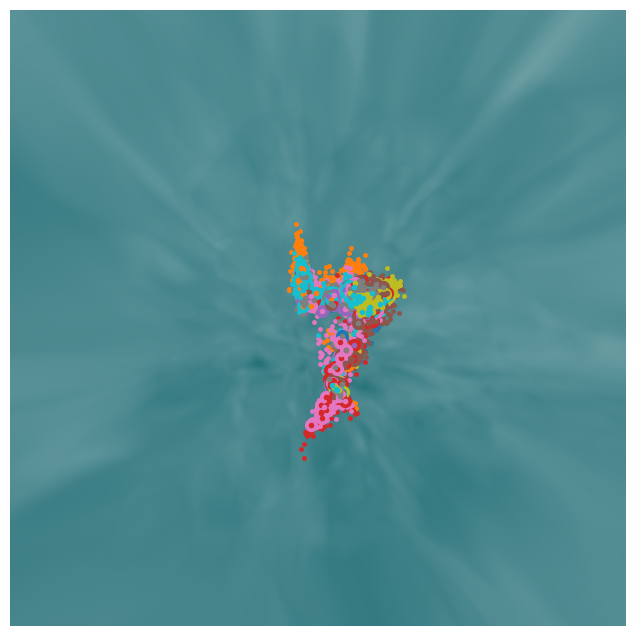

In [3]:
##### visuallize all data
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
VIS_MODEL_NAME = 'vis'
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
Y = torch.Tensor(tar_provider.train_representation(TAR_EPOCH))
encoded_Y = autoencoder.encoder(Y)
I = np.eye(512)
from AlignVis_Visualizer.visualizer import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(tar_provider, ref_provider, autoencoder, np.dot(encoded_Y.detach().numpy(), I), projector, 200,[],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(REF_EPOCH, path=os.path.join(TAR_PATH, "vis.png"))

Computing decision regions ...


100%|██████████| 250/250 [00:00<00:00, 8259.11it/s]


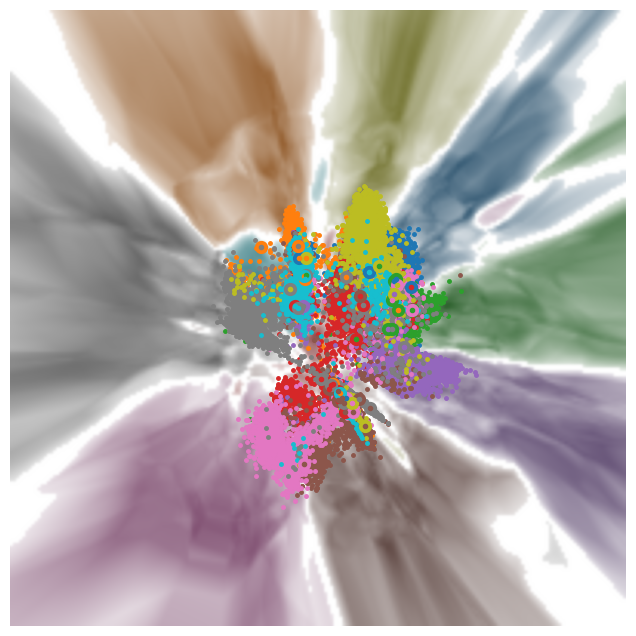

In [7]:
###### use auto encoder to visualize the prediction
X = torch.Tensor(ref_provider.train_representation(REF_EPOCH))
Y = torch.Tensor(tar_provider.train_representation(TAR_EPOCH))
# Transform X into Y's space
encoded_X = autoencoder.decoder(X)
VIS_MODEL_NAME = 'vis'
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
###### use auto encoder to visualize the prediction
Y = torch.Tensor(ref_provider.train_representation(REF_EPOCH))
X = torch.Tensor(tar_provider.train_representation(TAR_EPOCH))
# Transform X into Y's space
encoded_X = autoencoder.decoder(X)

# Transform Y into X's space
encoded_Y = autoencoder.encoder(Y)

projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

I = np.eye(512)
from AlignVisAutoEncoder.visualizer_inv import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(tar_provider, ref_provider, autoencoder, np.dot(encoded_X.detach().numpy(), I), projector, 200,[],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(REF_EPOCH, path=os.path.join("/home/yifan/projects/deepdebugertool/DLVisDebugger/alignment_evaluation/img2.png"))

Computing decision regions ...


100%|██████████| 250/250 [00:00<00:00, 4524.64it/s]


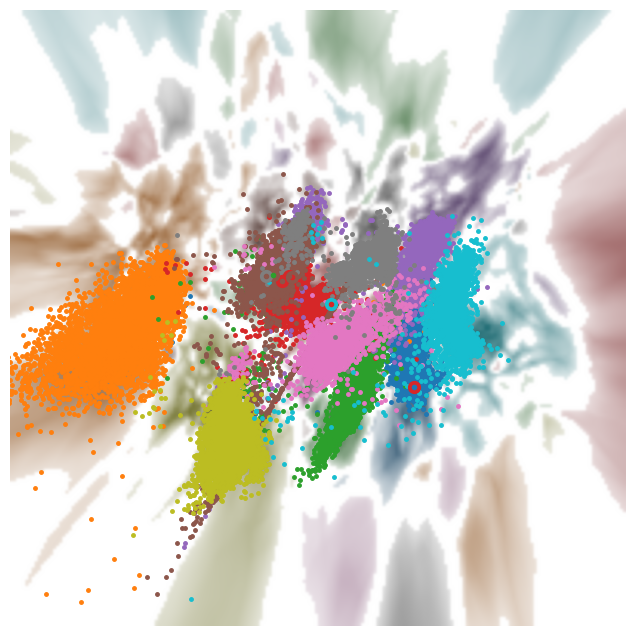

In [17]:
###### use auto encoder to visualize the prediction
X = torch.Tensor(ref_provider.train_representation(REF_EPOCH))
Y = torch.Tensor(tar_provider.train_representation(TAR_EPOCH))
# Transform X into Y's space
encoded_X = autoencoder.decoder(X)
VIS_MODEL_NAME = 'baseline'
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)

projector = TimeVisProjector(vis_model=model, content_path=CLEAN_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

I = np.eye(512)
from AlignVisAutoEncoder.visualizer_inv import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(ref_provider, tar_provider, autoencoder, np.dot(encoded_X.detach().numpy(), I), projector, 200,[],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(REF_EPOCH, path=os.path.join("/home/yifan/projects/deepdebugertool/DLVisDebugger/alignment_evaluation/img2.png"))

Computing decision regions ...


100%|██████████| 250/250 [00:00<00:00, 7735.31it/s]


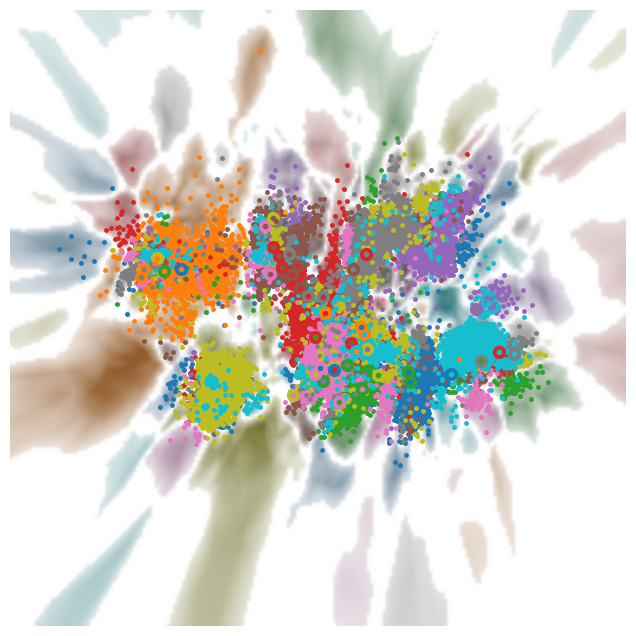

In [8]:


import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
VIS_MODEL_NAME = 'baseline'
projector = TimeVisProjector(vis_model=model, content_path=CLEAN_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

I = np.eye(512)
# from AlignVisAutoEncoder.visualizer_inv import visualizer
from representationTrans.trans_visualizer_border import visualizer
vis = visualizer(tar_provider, I,I, np.dot(tar_train_data, I), projector, 200,[],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(REF_EPOCH, path=os.path.join("/home/yifan/projects/deepdebugertool/DLVisDebugger/alignment_evaluation/img2.png"))

In [40]:
from AlignVis.AlignSimilarityScaler import AlignSimilarityScaler

AlignSimilarity_scaler = AlignSimilarityScaler(REF_PATH, REF_PATH, TAR_PATH, TAR_PATH, 200,200, DEVICE)

NET resnet18
Finish initialization...


100%|██████████| 250/250 [00:00<00:00, 8619.33it/s]


NET resnet18
Finish initialization...


100%|██████████| 250/250 [00:00<00:00, 8464.38it/s]


In [41]:
sim_list_all = AlignSimilarity_scaler.get_jaccard_similarities(ref_train_data, tar_train_data, 10)

In [42]:
def normalize_distances(distances):
    d_max = torch.max(distances)
    return distances / d_max

def weighted_harmonic_mean(jaccard_similarities, normalized_distances, alpha=0.5):
    numerator = (1 + alpha) * jaccard_similarities * (1 - normalized_distances)
    denominator = alpha * (1 - normalized_distances) + jaccard_similarities
    return numerator / denominator

def evaluate_alignment_preserving(subset_distances, subset_jaccard_similarities, alpha=0.5):
    normalized_distances = normalize_distances(subset_distances)
    harmonic_means = weighted_harmonic_mean(subset_jaccard_similarities, normalized_distances, alpha)
    return torch.mean(harmonic_means)

In [43]:
# Transform Y into X's space
encoded_Y = autoencoder.encoder(Y)
c_y = encoded_Y.detach().numpy()
from sklearn.metrics import pairwise_distances
distances2 = pairwise_distances(ref_train_data, encoded_Y.detach().numpy())
print(len(ref_train_data),"all data samples distance" ,distances2.mean())

50000 all data samples distance 20.036068


In [44]:
val = distances2.mean() // 1.5

In [61]:
num=0
indices = [i for i, score in enumerate(sim_list_all) if score >0.950]
len(indices)
dis = []
for i in range(len(indices)):
    index = indices[i]
    # dis.append(distances2[index][index])
    if distances2[index][index] < val:
        num = num+1
        print("num",i,len(indices), num)


num 1 4856 1
num 2 4856 2
num 4 4856 3
num 5 4856 4
num 6 4856 5
num 7 4856 6
num 9 4856 7
num 11 4856 8
num 12 4856 9
num 13 4856 10
num 14 4856 11
num 15 4856 12
num 17 4856 13
num 18 4856 14
num 22 4856 15
num 23 4856 16
num 25 4856 17
num 26 4856 18
num 27 4856 19
num 28 4856 20
num 29 4856 21
num 30 4856 22
num 31 4856 23
num 32 4856 24
num 33 4856 25
num 34 4856 26
num 35 4856 27
num 36 4856 28
num 37 4856 29
num 38 4856 30
num 39 4856 31
num 40 4856 32
num 41 4856 33
num 42 4856 34
num 43 4856 35
num 44 4856 36
num 45 4856 37
num 46 4856 38
num 47 4856 39
num 48 4856 40
num 49 4856 41
num 50 4856 42
num 51 4856 43
num 52 4856 44
num 54 4856 45
num 55 4856 46
num 57 4856 47
num 58 4856 48
num 60 4856 49
num 61 4856 50
num 64 4856 51
num 65 4856 52
num 66 4856 53
num 67 4856 54
num 69 4856 55
num 71 4856 56
num 72 4856 57
num 73 4856 58
num 74 4856 59
num 75 4856 60
num 76 4856 61
num 78 4856 62
num 79 4856 63
num 81 4856 64
num 82 4856 65
num 83 4856 66
num 84 4856 67
num 85 4856

In [62]:
indices = [i for i, score in enumerate(sim_list_all) if score >0.951]
print("{}/{}".format(num,len(indices)))

3680/4856
